In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import datetime
import shap
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
import numpy as np

c:\Users\Caesar\Desktop\fintech-fraud-ai-Chigozie-Hyginus-Ifenji\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Saving data to dataframe
df = pd.read_excel("fintech_sample_fintech_transactions (003).csv(4).xlsx")

## EXPLORATORY DATA ANALYSIS

In [3]:
dataFrame = df.copy()

# check for null values
print("Null Values: ", dataFrame.isnull().sum().sum())

# check for unique labels
print("Unique labels: ", dataFrame["label_code"].unique())

# check for duplicates
print("Duplicates: ", dataFrame.duplicated().sum()) 

# Check for balance
fraud = dataFrame[dataFrame["label_code"] == 1]
no_fraud = dataFrame[dataFrame["label_code"] == 0]
print(f"fraud cases: {len(fraud)}")
print(f"non fraud cases: {len(no_fraud)}")

# Print unique values for each column
categorical_cols = dataFrame.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols.remove("transaction_id")
categorical_cols.remove("customer_id")

for col in categorical_cols:
    print(f"{col}: {len(dataFrame[col].unique())} - {dataFrame[col].unique()}")

Null Values:  0
Unique labels:  [1 0]
Duplicates:  0
fraud cases: 171
non fraud cases: 829
transaction_type: 4 - ['Online' 'POS' 'ATM' 'Transfer']
device_type: 4 - ['Mobile' 'ATM Machine' 'POS Terminal' 'Web']
location: 5 - ['Abuja' 'Lagos' 'Ibadan' 'Kano' 'Port Harcourt']
time_of_day: 4 - ['Afternoon' 'Evening' 'Morning' 'Night']
day_of_week: 7 - ['Fri' 'Tue' 'Wed' 'Sun' 'Thu' 'Mon' 'Sat']


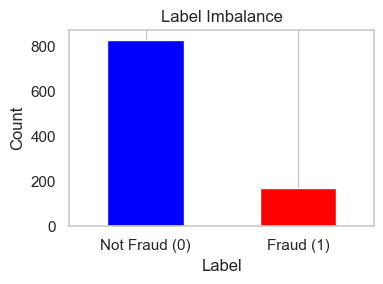

In [22]:
# Plot Data Imbalance
label_counts = dataFrame['label_code'].value_counts()

# Plot
plt.figure(figsize=(4, 3))
label_counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Label Imbalance')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Not Fraud (0)', 'Fraud (1)'], rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [4]:
# Validate Time and day column using timestamp
dataFrame['transaction_time'] = pd.to_datetime(dataFrame['transaction_time'])
timestamp = dataFrame.iloc[0]['transaction_time']
print(timestamp)

# validate day of the week
day_of_week = dataFrame.iloc[0]["day_of_week"]
print(f'Day of week from dataFrame: {day_of_week}\nDay of the week from timestamp: {timestamp.strftime("%A")[:3]}\nValidity: {day_of_week == timestamp.strftime("%A")[:3]}')

# validate time of the day
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'
    
print(f"Time of day from dataframe: {dataFrame.iloc[0]['time_of_day']}\nTime of day from timestamp: {get_time_of_day(timestamp.hour)}\nValidity: {get_time_of_day(timestamp.hour) == dataFrame.iloc[0]["time_of_day"]}")

2024-02-04 22:00:00
Day of week from dataFrame: Fri
Day of the week from timestamp: Sun
Validity: False
Time of day from dataframe: Afternoon
Time of day from timestamp: Night
Validity: False


In [5]:
# Replace time of day and day of week in dataFrame using Timestamp
dataFrame['day_of_week'] = dataFrame['transaction_time'].dt.day_name().str[:3]
dataFrame['time_of_day'] = dataFrame['transaction_time'].dt.hour.apply(get_time_of_day)
dataFrame

,transaction_id,customer_id,transaction_amount,transaction_type,device_type,location,time_of_day,day_of_week,is_foreign_transaction,is_high_risk_country,previous_fraud_flag,label_code,transaction_time,risk_score
0,TX100703,CUST1092,5.278908,Online,Mobile,Abuja,Night,Sun,0,1,0,1,2024-02-04 22:00:00,0.079284
1,TX100182,CUST1021,205.156878,Online,ATM Machine,Lagos,Night,Wed,0,0,0,0,2024-01-17 04:00:00,2.358645
2,TX100221,CUST1100,77.715851,POS,POS Terminal,Ibadan,Afternoon,Sat,0,1,0,1,2024-01-13 15:00:00,1.794567
3,TX100528,CUST1099,8.440649,ATM,POS Terminal,Kano,Morning,Thu,0,0,0,0,2024-01-18 06:00:00,0.095569
4,TX100776,CUST1014,11.125070,Online,POS Terminal,Port Harcourt,Morning,Mon,1,0,0,1,2024-02-05 07:00:00,0.176721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,TX100510,CUST1054,71.601431,ATM,Mobile,Ibadan,Afternoon,Sat,1,0,0,1,2024-02-03 16:00:00,1.176474
996,TX100350,CUST1073,50.081930,ATM,POS Terminal,Ibadan,Night,Tue,0,1,0,1,2024-01-23 23:00:00,0.685367
997,TX100427,CUST1013,157.707879,Transfer,Web,Kano,Morning,Sun,0,0,0,0,2024-02-11 05:00:00,1.169893
998,TX100306,CUST1039,65.532316,ATM,POS Terminal,Ibadan,Evening,Sun,0,0,0,0,2024-01-21 18:00:00,0.457505


In [6]:
plot_cols = categorical_cols + ["is_foreign_transaction", "is_high_risk_country", "previous_fraud_flag"]
print(plot_cols)

['transaction_type', 'device_type', 'location', 'time_of_day', 'day_of_week', 'is_foreign_transaction', 'is_high_risk_country', 'previous_fraud_flag']


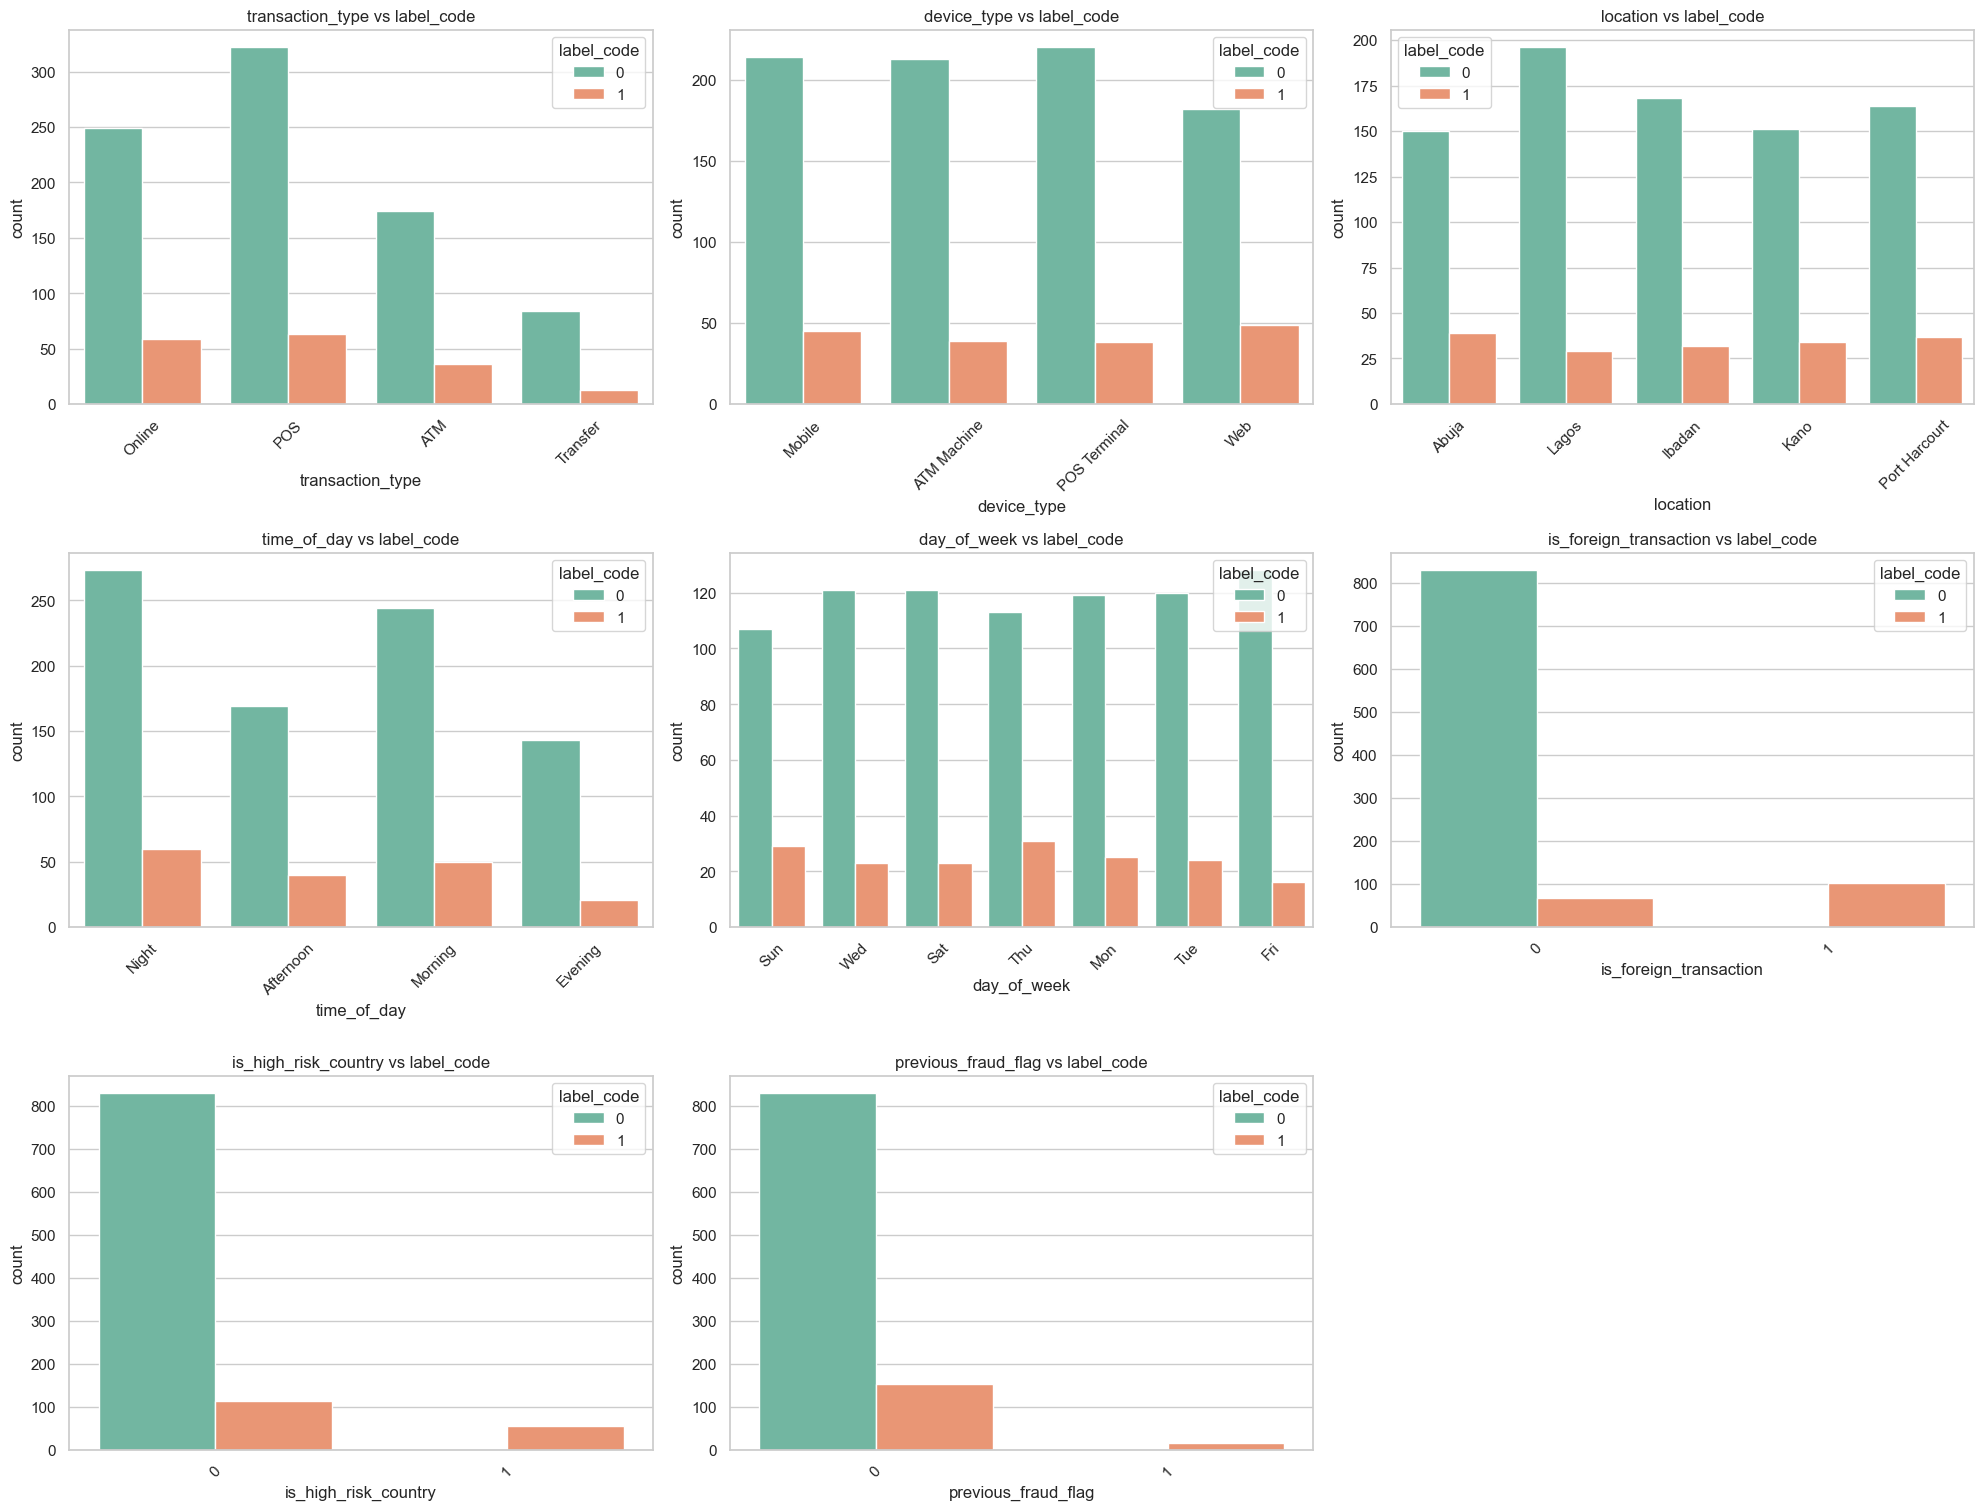

In [7]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(20, 20))
for i, feature in enumerate(plot_cols, 1):
    plt.subplot(4, 3, i)
    sns.countplot(data=dataFrame, x=feature, hue="label_code", palette="Set2")
    plt.title(f"{feature} vs label_code")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### TEMPORAL ANALYSIS PATTERN ANAYSLIS

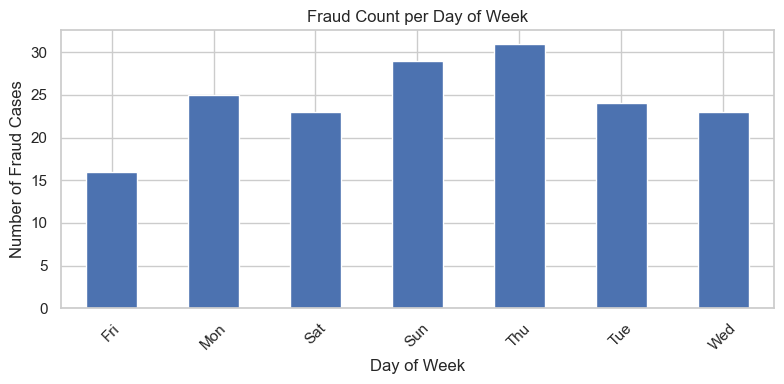

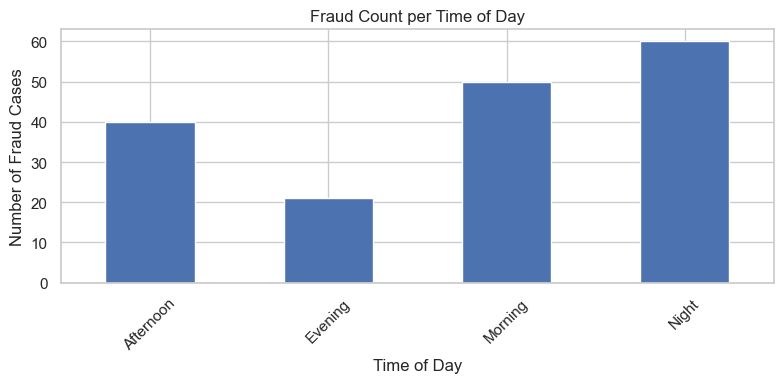

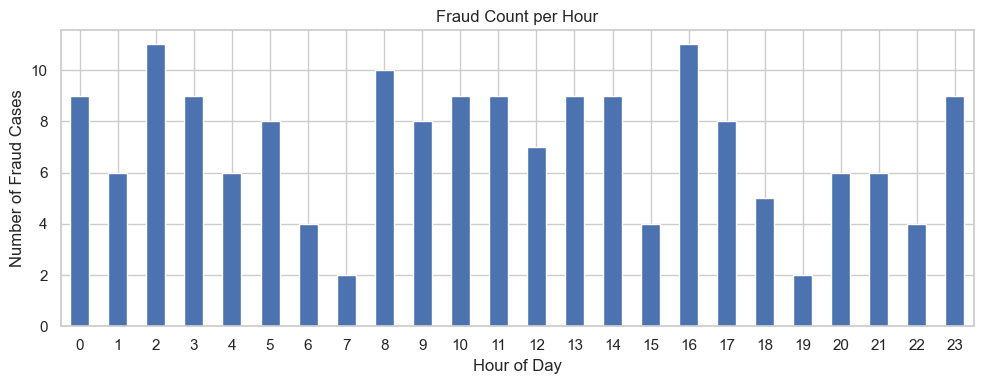

In [ ]:
dataFrame['transaction_time'] = pd.to_datetime(dataFrame['transaction_time'])

# Extract hour from transaction_time
dataFrame['hour'] = dataFrame['transaction_time'].dt.hour

fraud_per_day = dataFrame[dataFrame["label_code"] == 1]["day_of_week"]
fraud_per_time = dataFrame[dataFrame["label_code"] == 1]["time_of_day"]
fraud_per_hour = dataFrame[dataFrame["label_code"] == 1]["hour"]

# plot bar chats

plt.figure(figsize=(8, 4))
fraud_per_day.value_counts().sort_index().plot(kind='bar')
plt.title("Fraud Count per Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Fraud Cases")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Fraud count per time of day (e.g., Morning, Afternoon, etc.)
plt.figure(figsize=(8, 4))
fraud_per_time.value_counts().sort_index().plot(kind='bar')
plt.title("Fraud Count per Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Number of Fraud Cases")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Fraud count per hour (0–23)
plt.figure(figsize=(10, 4))
fraud_per_hour.value_counts().sort_index().plot(kind='bar')
plt.title("Fraud Count per Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Fraud Cases")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### FEATURE ENGINEERING

In [9]:
one_hot_col = ["transaction_type", "location", "device_type"]
cyclical_col = ["day_of_week", "time_of_day"]

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(dataFrame[one_hot_col])
encoded_df = pd.DataFrame(
    encoded, 
    columns=encoder.get_feature_names_out(one_hot_col)
)
# Save the fitted encoder
joblib.dump(encoder, "models/onehot_encoder.pkl")

['models/onehot_encoder.pkl']

In [10]:
dataFrame = pd.concat([dataFrame, encoded_df], axis=1)
dataFrame.drop(columns=one_hot_col, inplace=True)

dataFrame

,transaction_id,customer_id,transaction_amount,time_of_day,day_of_week,is_foreign_transaction,is_high_risk_country,previous_fraud_flag,label_code,transaction_time,...,transaction_type_Transfer,location_Abuja,location_Ibadan,location_Kano,location_Lagos,location_Port Harcourt,device_type_ATM Machine,device_type_Mobile,device_type_POS Terminal,device_type_Web
0,TX100703,CUST1092,5.278908,Night,Sun,0,1,0,1,2024-02-04 22:00:00,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,TX100182,CUST1021,205.156878,Night,Wed,0,0,0,0,2024-01-17 04:00:00,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,TX100221,CUST1100,77.715851,Afternoon,Sat,0,1,0,1,2024-01-13 15:00:00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,TX100528,CUST1099,8.440649,Morning,Thu,0,0,0,0,2024-01-18 06:00:00,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,TX100776,CUST1014,11.125070,Morning,Mon,1,0,0,1,2024-02-05 07:00:00,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,TX100510,CUST1054,71.601431,Afternoon,Sat,1,0,0,1,2024-02-03 16:00:00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
996,TX100350,CUST1073,50.081930,Night,Tue,0,1,0,1,2024-01-23 23:00:00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
997,TX100427,CUST1013,157.707879,Morning,Sun,0,0,0,0,2024-02-11 05:00:00,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
998,TX100306,CUST1039,65.532316,Evening,Sun,0,0,0,0,2024-01-21 18:00:00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [11]:
time_map = {'Morning': 0, 'Afternoon': 1, 'Evening': 2, 'Night': 3}
dataFrame['time_num'] = dataFrame['time_of_day'].map(time_map)

dataFrame['time_sin'] = np.sin(2 * np.pi * dataFrame['time_num'] / 4)
dataFrame['time_cos'] = np.cos(2 * np.pi * dataFrame['time_num'] / 4)

dataFrame.drop(columns=['time_of_day', 'time_num'], inplace=True)

dataFrame

,transaction_id,customer_id,transaction_amount,day_of_week,is_foreign_transaction,is_high_risk_country,previous_fraud_flag,label_code,transaction_time,risk_score,...,location_Ibadan,location_Kano,location_Lagos,location_Port Harcourt,device_type_ATM Machine,device_type_Mobile,device_type_POS Terminal,device_type_Web,time_sin,time_cos
0,TX100703,CUST1092,5.278908,Sun,0,1,0,1,2024-02-04 22:00:00,0.079284,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.000000e+00,-1.836970e-16
1,TX100182,CUST1021,205.156878,Wed,0,0,0,0,2024-01-17 04:00:00,2.358645,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-1.000000e+00,-1.836970e-16
2,TX100221,CUST1100,77.715851,Sat,0,1,0,1,2024-01-13 15:00:00,1.794567,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.000000e+00,6.123234e-17
3,TX100528,CUST1099,8.440649,Thu,0,0,0,0,2024-01-18 06:00:00,0.095569,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000e+00,1.000000e+00
4,TX100776,CUST1014,11.125070,Mon,1,0,0,1,2024-02-05 07:00:00,0.176721,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.000000e+00,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,TX100510,CUST1054,71.601431,Sat,1,0,0,1,2024-02-03 16:00:00,1.176474,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.000000e+00,6.123234e-17
996,TX100350,CUST1073,50.081930,Tue,0,1,0,1,2024-01-23 23:00:00,0.685367,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.000000e+00,-1.836970e-16
997,TX100427,CUST1013,157.707879,Sun,0,0,0,0,2024-02-11 05:00:00,1.169893,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000e+00,1.000000e+00
998,TX100306,CUST1039,65.532316,Sun,0,0,0,0,2024-01-21 18:00:00,0.457505,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.224647e-16,-1.000000e+00


In [12]:
day_map = {'Mon': 0, 'Tue': 1, 'Wed': 2, 'Thu': 3, 'Fri': 4, 'Sat': 5, 'Sun': 6}
dataFrame['day_num'] = dataFrame['day_of_week'].map(day_map)

dataFrame['day_sin'] = np.sin(2 * np.pi * dataFrame['day_num'] / 7)
dataFrame['day_cos'] = np.cos(2 * np.pi * dataFrame['day_num'] / 7)

dataFrame.drop(columns=['day_of_week', 'day_num'], inplace=True)   

dataFrame

,transaction_id,customer_id,transaction_amount,is_foreign_transaction,is_high_risk_country,previous_fraud_flag,label_code,transaction_time,risk_score,hour,...,location_Lagos,location_Port Harcourt,device_type_ATM Machine,device_type_Mobile,device_type_POS Terminal,device_type_Web,time_sin,time_cos,day_sin,day_cos
0,TX100703,CUST1092,5.278908,0,1,0,1,2024-02-04 22:00:00,0.079284,22,...,0.0,0.0,0.0,1.0,0.0,0.0,-1.000000e+00,-1.836970e-16,-0.781831,0.623490
1,TX100182,CUST1021,205.156878,0,0,0,0,2024-01-17 04:00:00,2.358645,4,...,1.0,0.0,1.0,0.0,0.0,0.0,-1.000000e+00,-1.836970e-16,0.974928,-0.222521
2,TX100221,CUST1100,77.715851,0,1,0,1,2024-01-13 15:00:00,1.794567,15,...,0.0,0.0,0.0,0.0,1.0,0.0,1.000000e+00,6.123234e-17,-0.974928,-0.222521
3,TX100528,CUST1099,8.440649,0,0,0,0,2024-01-18 06:00:00,0.095569,6,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000e+00,1.000000e+00,0.433884,-0.900969
4,TX100776,CUST1014,11.125070,1,0,0,1,2024-02-05 07:00:00,0.176721,7,...,0.0,1.0,0.0,0.0,1.0,0.0,0.000000e+00,1.000000e+00,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,TX100510,CUST1054,71.601431,1,0,0,1,2024-02-03 16:00:00,1.176474,16,...,0.0,0.0,0.0,1.0,0.0,0.0,1.000000e+00,6.123234e-17,-0.974928,-0.222521
996,TX100350,CUST1073,50.081930,0,1,0,1,2024-01-23 23:00:00,0.685367,23,...,0.0,0.0,0.0,0.0,1.0,0.0,-1.000000e+00,-1.836970e-16,0.781831,0.623490
997,TX100427,CUST1013,157.707879,0,0,0,0,2024-02-11 05:00:00,1.169893,5,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000e+00,1.000000e+00,-0.781831,0.623490
998,TX100306,CUST1039,65.532316,0,0,0,0,2024-01-21 18:00:00,0.457505,18,...,0.0,0.0,0.0,0.0,1.0,0.0,1.224647e-16,-1.000000e+00,-0.781831,0.623490


In [13]:
print(dataFrame["transaction_amount"].describe())

scaler = RobustScaler()
scaled = scaler.fit_transform(dataFrame[["transaction_amount"]])
dataFrame["transaction_amount"] = scaled

joblib.dump(scaler, "models/robust_scaler.pkl")

dataFrame

count    1000.000000
mean       72.595107
std        73.350547
min       -17.066703
25%        21.041597
50%        50.376081
75%       102.785040
max       608.378011
Name: transaction_amount, dtype: float64


,transaction_id,customer_id,transaction_amount,is_foreign_transaction,is_high_risk_country,previous_fraud_flag,label_code,transaction_time,risk_score,hour,...,location_Lagos,location_Port Harcourt,device_type_ATM Machine,device_type_Mobile,device_type_POS Terminal,device_type_Web,time_sin,time_cos,day_sin,day_cos
0,TX100703,CUST1092,-0.551692,0,1,0,1,2024-02-04 22:00:00,0.079284,22,...,0.0,0.0,0.0,1.0,0.0,0.0,-1.000000e+00,-1.836970e-16,-0.781831,0.623490
1,TX100182,CUST1021,1.893495,0,0,0,0,2024-01-17 04:00:00,2.358645,4,...,1.0,0.0,1.0,0.0,0.0,0.0,-1.000000e+00,-1.836970e-16,0.974928,-0.222521
2,TX100221,CUST1100,0.334458,0,1,0,1,2024-01-13 15:00:00,1.794567,15,...,0.0,0.0,0.0,0.0,1.0,0.0,1.000000e+00,6.123234e-17,-0.974928,-0.222521
3,TX100528,CUST1099,-0.513013,0,0,0,0,2024-01-18 06:00:00,0.095569,6,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000e+00,1.000000e+00,0.433884,-0.900969
4,TX100776,CUST1014,-0.480173,1,0,0,1,2024-02-05 07:00:00,0.176721,7,...,0.0,1.0,0.0,0.0,1.0,0.0,0.000000e+00,1.000000e+00,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,TX100510,CUST1054,0.259658,1,0,0,1,2024-02-03 16:00:00,1.176474,16,...,0.0,0.0,0.0,1.0,0.0,0.0,1.000000e+00,6.123234e-17,-0.974928,-0.222521
996,TX100350,CUST1073,-0.003598,0,1,0,1,2024-01-23 23:00:00,0.685367,23,...,0.0,0.0,0.0,0.0,1.0,0.0,-1.000000e+00,-1.836970e-16,0.781831,0.623490
997,TX100427,CUST1013,1.313032,0,0,0,0,2024-02-11 05:00:00,1.169893,5,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000e+00,1.000000e+00,-0.781831,0.623490
998,TX100306,CUST1039,0.185412,0,0,0,0,2024-01-21 18:00:00,0.457505,18,...,0.0,0.0,0.0,0.0,1.0,0.0,1.224647e-16,-1.000000e+00,-0.781831,0.623490


In [14]:
dataFrame["foreign_or_high_risk"] = dataFrame["is_foreign_transaction"] + dataFrame["is_high_risk_country"]

In [15]:
dataFrame.drop(columns=['transaction_id', 'customer_id', "hour", 'transaction_time'], inplace=True)

print(list(dataFrame.columns))
dataFrame

['transaction_amount', 'is_foreign_transaction', 'is_high_risk_country', 'previous_fraud_flag', 'label_code', 'risk_score', 'transaction_type_ATM', 'transaction_type_Online', 'transaction_type_POS', 'transaction_type_Transfer', 'location_Abuja', 'location_Ibadan', 'location_Kano', 'location_Lagos', 'location_Port Harcourt', 'device_type_ATM Machine', 'device_type_Mobile', 'device_type_POS Terminal', 'device_type_Web', 'time_sin', 'time_cos', 'day_sin', 'day_cos', 'foreign_or_high_risk']


,transaction_amount,is_foreign_transaction,is_high_risk_country,previous_fraud_flag,label_code,risk_score,transaction_type_ATM,transaction_type_Online,transaction_type_POS,transaction_type_Transfer,...,location_Port Harcourt,device_type_ATM Machine,device_type_Mobile,device_type_POS Terminal,device_type_Web,time_sin,time_cos,day_sin,day_cos,foreign_or_high_risk
0,-0.551692,0,1,0,1,0.079284,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-1.000000e+00,-1.836970e-16,-0.781831,0.623490,1
1,1.893495,0,0,0,0,2.358645,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,-1.000000e+00,-1.836970e-16,0.974928,-0.222521,0
2,0.334458,0,1,0,1,1.794567,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.000000e+00,6.123234e-17,-0.974928,-0.222521,1
3,-0.513013,0,0,0,0,0.095569,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.000000e+00,1.000000e+00,0.433884,-0.900969,0
4,-0.480173,1,0,0,1,0.176721,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.000000e+00,1.000000e+00,0.000000,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.259658,1,0,0,1,1.176474,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.000000e+00,6.123234e-17,-0.974928,-0.222521,1
996,-0.003598,0,1,0,1,0.685367,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-1.000000e+00,-1.836970e-16,0.781831,0.623490,1
997,1.313032,0,0,0,0,1.169893,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.000000e+00,1.000000e+00,-0.781831,0.623490,0
998,0.185412,0,0,0,0,0.457505,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.224647e-16,-1.000000e+00,-0.781831,0.623490,0


In [16]:
X = dataFrame.drop("label_code", axis=1)
y = dataFrame["label_code"]


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=32)

smote_enn = SMOTEENN(random_state=32)
X_balanced, y_balanced = smote_enn.fit_resample(X_train, y_train)

In [ ]:
print("Total: ", len(y_train))              # Before
print(1, len(y_train[y_train == 1]))
print(0, len(y_train[y_train == 0]))
print("Total: ", len(y_balanced))           # After
print(1, len(y_balanced[y_balanced == 1]))
print(0, len(y_balanced[y_balanced == 0]))

Total:  800
1 137
0 663
Total:  1277
1 656
0 621


In [ ]:
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=32
)

model.fit(X_balanced, y_balanced)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [20]:
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[166   0]
 [  0  34]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       166
           1       1.00      1.00      1.00        34

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [21]:
joblib.dump(model, "models/xgb_model.pkl")

['models/xgb_model.pkl']

### MODEL EXPLAINABILITY

In [22]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

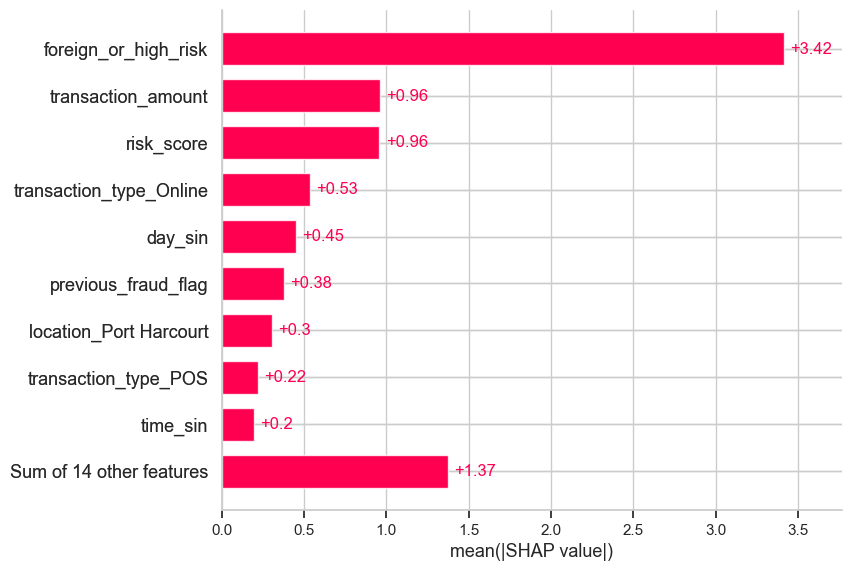

In [23]:
shap.plots.bar(shap_values)

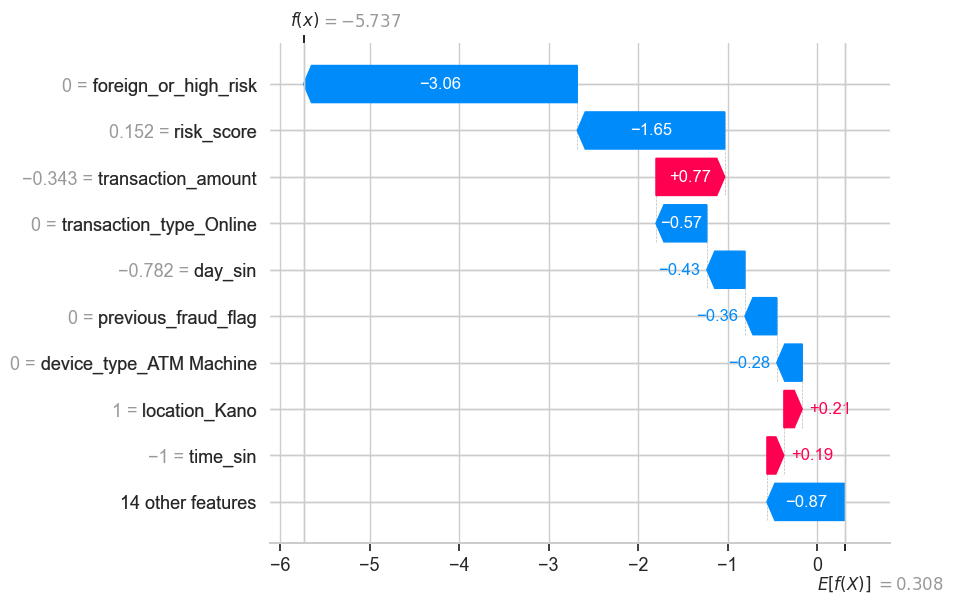

In [24]:
# For first test example
shap.plots.waterfall(shap_values[0])